In [6]:
import os
import numpy as np
from typing import List
from scipy.stats import beta
import matplotlib.pyplot as plt
import cohere
from dotenv import load_dotenv

from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load environment variables from a .env file
load_dotenv()

True

In [7]:
def split_into_chunks(text: str, chunk_size: int):
    """
    Split a given text into chunks of specified size using RecursiveCharacterTextSplitter.

    Args:
        text (str): The input text to be split into chunks.
        chunk_size (int, optional): The maximum size of each chunk. Defaults to 800.

    Returns:
        list[str]: A list of text chunks.

    Example:
        >>> text = "This is a sample text to be split into chunks."
        >>> chunks = split_into_chunks(text, chunk_size=10)
        >>> print(chunks)
        ['This is a', 'sample', 'text to', 'be split', 'into', 'chunks.']
    """
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=0, length_function=len)
    texts = text_splitter.create_documents([text])
    chunks = [text.page_content for text in texts]
    return chunks

In [8]:
def transform(x: float):
    """
    Transformation function to map the absolute relevance value to a value that is more uniformly distributed between 0 and 1. The relevance values given by the Cohere reranker tend to be very close to 0 or 1. This beta function used here helps to spread out the values more uniformly.

    Args:
        x (float): The absolute relevance value returned by the Cohere reranker

    Returns:
        float: The transformed relevance value
    """
    a, b = 0.4, 0.4  # These can be adjusted to change the distribution shape
    return beta.cdf(x, a, b)

In [9]:
def rerank_chunks(query: str, chunks: List[str]):
    """
    Use Cohere Rerank API to rerank the search results

    Args:
        query (str): The search query
        chunks (list): List of chunks to be reranked

    Returns:
        similarity_scores (list): List of similarity scores for each chunk
        chunk_values (list): List of relevance values (fusion of rank and similarity) for each chunk
    """
    model = "rerank-english-v3.0"
    client = cohere.Client()
    decay_rate = 30

    reranked_results = client.rerank(model=model, query=query, documents=chunks)
    results = reranked_results.results
    reranked_indices = [result.index for result in results]
    reranked_similarity_scores = [result.relevance_score for result in results] # in order of reranked_indices
    
    # convert back to order of original documents and calculate the chunk values
    similarity_scores = [0] * len(chunks)
    chunk_values = [0] * len(chunks)
    for i, index in enumerate(reranked_indices):
        absolute_relevance_value = transform(reranked_similarity_scores[i])
        similarity_scores[index] = absolute_relevance_value
        chunk_values[index] = np.exp(-i/decay_rate)*absolute_relevance_value # decay the relevance value based on the rank

    return similarity_scores, chunk_values

In [10]:
def plot_relevance_scores(chunk_values: List[float], start_index: int = None, end_index: int = None) -> None:
    """
    Visualize the relevance scores of each chunk in the document to the search query

    Args:
        chunk_values (list): List of relevance values for each chunk
        start_index (int): Start index of the chunks to be plotted
        end_index (int): End index of the chunks to be plotted

    Returns:
        None

    Plots:
        Scatter plot of the relevance scores of each chunk in the document to the search query
    """
    plt.figure(figsize=(12, 5))
    plt.title(f"Similarity of each chunk in the document to the search query")
    plt.ylim(0, 1)
    plt.xlabel("Chunk index")
    plt.ylabel("Query-chunk similarity")
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(chunk_values)
    plt.scatter(range(start_index, end_index), chunk_values[start_index:end_index])

In [13]:
FILE_PATH = "RAG_TECHNIQUES/data/nike_2023_annual_report.txt"

with open(FILE_PATH, 'r') as file:
    text = file.read()

chunks = split_into_chunks(text, chunk_size=800)

print (f"Split the document into {len(chunks)} chunks")

Split the document into 500 chunks


In [18]:
query = "Nike's sales statistics"

similarity_scores, chunk_values = rerank_chunks(query, chunks)

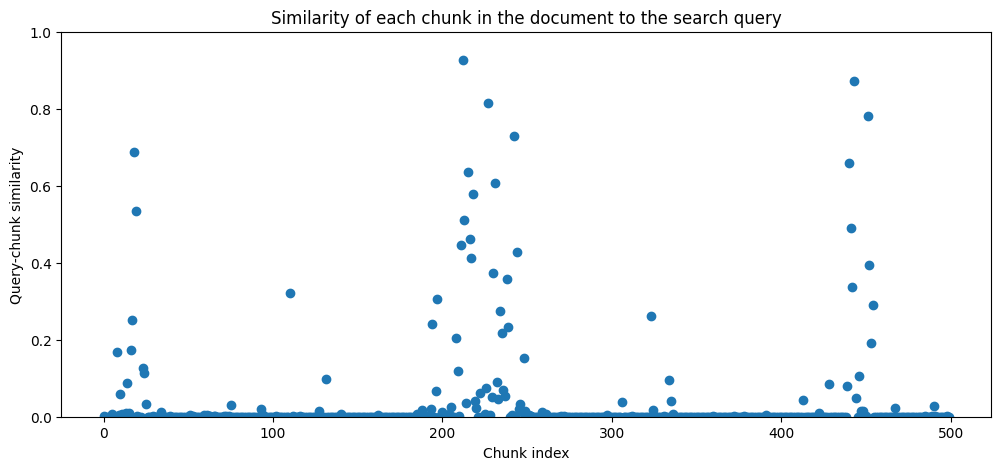

In [19]:
plot_relevance_scores(chunk_values)

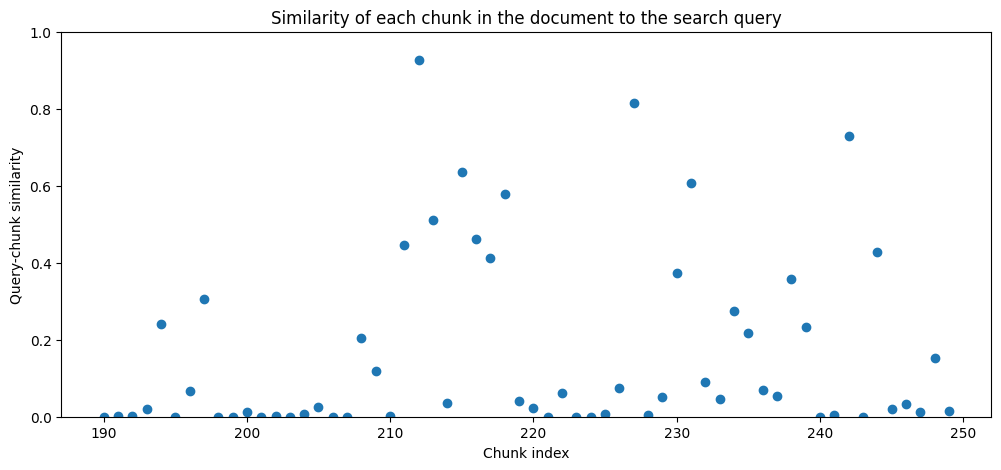

In [21]:
plot_relevance_scores(chunk_values, 190, 250)

In [23]:
def print_document_segment(chunks: List[str], start_index: int, end_index: int):
    """
    Print the text content of a segment of the document

    Args:
        chunks (list): List of text chunks
        start_index (int): Start index of the segment
        end_index (int): End index of the segment (not inclusive)

    Returns:
        None

    Prints:
        The text content of the specified segment of the document
    """
    for i in range(start_index, end_index):
        print(f"\nChunk {i}")
        print(chunks[i])

In [24]:
print_document_segment(chunks, 212, 218)


Chunk 212
TOTAL NIKE, INC. REVENUES $ 51,217 $ 46,710  10 %  16 % $ 44,538  5 %  6 %
Supplemental NIKE Brand Revenues Details:
NIKE Brand Revenues by:
Sales to Wholesale Customers $ 27,397 $ 25,608  7 %  14 % $ 25,898  -1 %  -1 %
Sales through NIKE Direct  21,308  18,726  14 %  20 %  16,370  14 %  15 %
Global Brand Divisions(2) 58  102  -43 %  -43 %  25  308 %  302 %
TOTAL NIKE BRAND REVENUES $ 48,763 $ 44,436  10 %  16 % $ 42,293  5 %  6 %
NIKE Brand Revenues on a Wholesale Equivalent 
Basis(1):
Sales to Wholesale Customers $ 27,397 $ 25,608  7 %  14 % $ 25,898  -1 %  -1 %
Sales from our Wholesale Operations to NIKE Direct 
Operations  12,730  10,543  21 %  27 %  9,872  7 %  7 %
TOTAL NIKE BRAND WHOLESALE EQUIVALENT 
REVENUES $ 40,127 $ 36,151  11 %  18 % $ 35,770  1 %  1 %

Chunk 213
NIKE Brand Wholesale Equivalent Revenues by:(1),(4)
Men's $ 20,733 $ 18,797  10 %  17 % $ 18,391  2 %  3 %
Women's  8,606  8,273  4 %  11 %  8,225  1 %  1 %
NIKE Kids'  5,038  4,874  3 %  10 %  4,882  0

In [25]:
def get_best_segments(relevance_values: list, max_length: int, overall_max_length: int, minimum_value: float):
    """
    This function takes the chunk relevance values and then runs an optimization algorithm to find the best segments. In more technical terms, it solves a constrained version of the maximum sum subarray problem.

    Note: this is a simplified implementation intended for demonstration purposes. A more sophisticated implementation would be needed for production use and is available in the dsRAG library.

    Args:
        relevance_values (list): a list of relevance values for each chunk of a document
        max_length (int): the maximum length of a single segment (measured in number of chunks)
        overall_max_length (int): the maximum length of all segments (measured in number of chunks)
        minimum_value (float): the minimum value that a segment must have to be considered

    Returns:
        best_segments (list): a list of tuples (start, end) that represent the indices of the best segments (the end index is non-inclusive) in the document
        scores (list): a list of the scores for each of the best segments
    """
    best_segments = []
    scores = []
    total_length = 0
    while total_length < overall_max_length:
        # find the best remaining segment
        best_segment = None
        best_value = -1000
        for start in range(len(relevance_values)):
            # skip over negative value starting points
            if relevance_values[start] < 0:
                continue
            for end in range(start+1, min(start+max_length+1, len(relevance_values)+1)):
                # skip over negative value ending points
                if relevance_values[end-1] < 0:
                    continue
                # check if this segment overlaps with any of the best segments and skip if it does
                if any(start < seg_end and end > seg_start for seg_start, seg_end in best_segments):
                    continue
                # check if this segment would push us over the overall max length and skip if it would
                if total_length + end - start > overall_max_length:
                    continue
                
                # define segment value as the sum of the relevance values of its chunks
                segment_value = sum(relevance_values[start:end])
                if segment_value > best_value:
                    best_value = segment_value
                    best_segment = (start, end)
        
        # if we didn't find a valid segment then we're done
        if best_segment is None or best_value < minimum_value:
            break

        # otherwise, add the segment to the list of best segments
        best_segments.append(best_segment)
        scores.append(best_value)
        total_length += best_segment[1] - best_segment[0]
    
    return best_segments, scores

In [26]:
# define some parameters and constraints for the optimization
irrelevant_chunk_penalty = 0.2 # empirically, something around 0.2 works well; lower values bias towards longer segments
max_length = 20
overall_max_length = 30
minimum_value = 0.7

# subtract constant threshold value from chunk relevance values
relevance_values = [v - irrelevant_chunk_penalty for v in chunk_values] 

# run the optimization
best_segments, scores = get_best_segments(relevance_values, max_length, overall_max_length, minimum_value)

# print results
print ("Best segment indices")
print (best_segments) # indices of the best segments, with the end index non-inclusive
print ()
print ("Best segment scores")
print (scores)
print ()

Best segment indices
[(211, 219), (440, 444), (17, 20), (451, 455), (227, 232)]

Best segment scores
[np.float64(2.410412170120467), np.float64(1.5558136290917328), np.float64(0.8734136436026982), np.float64(0.8593568917675758), np.float64(0.8541710406182516)]

